In [10]:
import numpy as np
import copy
import scipy.io

In [11]:
mat = scipy.io.loadmat('/Users/nikitakocherin/Downloads/BlackBoxData.mat')
x = mat['x'][0]
y = mat['y'][0]
x = (x / np.linalg.norm(x))
y = (y / np.linalg.norm(y))

In [12]:
def generate_first_monom_dict(I, x):
    def generate_first_mon(bias, x):
        if bias == 0:
                return x
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return base
    result = []
    for i in range(-I, I + 1):
        result.append(generate_first_mon(i, x))
    return result

In [13]:
def generate_monom_dict(I, D, x):
    def generate_mon(bias, degree, x):
        if bias == 0:
            return np.power(np.absolute(x), degree)
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return np.power(np.absolute(base), degree)
    result = []
    for i in range(-I, I + 1):
        for j in range(D + 1):
            result.append(generate_mon(i, j, x))
    return result

In [14]:
def multiplicate(count, monom_dict):
    if count == 1:
        for i in monom_dict:
            yield i
    elif count == 2:
        for i in monom_dict:
            for j in monom_dict:
                yield i * j
    elif count == 3:
        for i in monom_dict:
            for j in monom_dict:
                for k in monom_dict:
                    yield i * j * k

In [18]:
def generate_real_dict_generator(I, D, M, x):
    monom_dict = generate_monom_dict(I, D, x)
    first_mon = generate_first_monom_dict(I, x)
    for i in first_mon:
        to_mult = multiplicate(M, monom_dict)
        for j in to_mult:
            k = i * j
            k = k / np.linalg.norm(k)
            yield k 

In [21]:
#y -- приближаем с помощью x
#u -- остаток, изначальный остаток -- y
#
def approximate_without_saving(x, y, I, D, M, flag=True):
    u_n = y
    iter = 0
    v_arr = []
    vector_norm = []
    norm_u_n_prev = 0
    u_n_prev = copy.deepcopy(u_n)
    while(np.linalg.norm(u_n) > 0.01 and iter < 1000):
        vector_norm.append(np.linalg.norm(u_n))
        if abs(np.linalg.norm(u_n) - norm_u_n_prev) < 0.0000001:
            break
        norm_u_n_prev = np.linalg.norm(u_n)
        v_n1 = None
        val = 0
        my_dict = generate_real_dict_generator(I, D, M, x)
        for i in my_dict:
            s = np.absolute(np.vdot(u_n, i))
            nor = abs(s)
            if nor > val:
                v_n1 = i
                val = nor
        h_n1_wave = copy.deepcopy(v_n1)
        if flag:
            for i in v_arr:
                #print("iter", iter)
                #print(np.vdot(v_n1, i), np.vdot(i, v_n1))
                h_n1_wave = h_n1_wave - np.vdot(i, v_n1) * i
        h_n1 = h_n1_wave / np.linalg.norm(h_n1_wave)
        v_arr.append(h_n1)
        u_n = u_n - np.vdot(h_n1, u_n) * h_n1 #поменял
        iter += 1
        if iter % 20 == 0:
            print(np.linalg.norm(u_n))
    print(np.linalg.norm(u_n), "iter:", iter)
    return vector_norm

In [22]:
%%time
v_norm_222_no_ort = approximate_without_saving(x, y, 2, 2, 2, flag=False)

0.11128126586900108
0.09986014158463716
0.09112624265971817
0.08432935343427764
0.07912715457580209
0.07534130826442093
0.0721439803203222
0.06970033730010385
0.0677223543414777
0.06601428977989882
0.06472392071466573
0.06362069957869074
0.06276534423336066
0.06207089993450143
0.06141572873603459
0.060882033775814214
0.06039673008660622
0.05996638716602934
0.05959800770138612
0.05927130799168378
0.05897077652276462
0.058696413752660756
0.058453792771223465
0.05824620593844652
0.05803193499831493
0.05786417341667071
0.05768235431255373
0.057508926719268494
0.05735231130961205
0.057197438929515926
0.05705520238566508
0.05692938826627151
0.05680881924333436
0.056689674305829295
0.05657366476928492
0.056472003637721355
0.05636068454679526
0.056258314005887274
0.05616160028583652
0.0560693297509504
0.05598388823851755
0.05589366287824777
0.0558123893228947
0.055733111747252
0.055651876814320114
0.05558588652423488
0.05551115994261018
0.055443543445916864
0.05537750093379218
0.05531771566351

In [23]:
%%time
u_norm_222 = approximate_without_saving(x, y, 2, 2, 2)

0.06538489239939564
0.05583293902304306
0.05003677189411938
0.04739865688126172
0.04217663780605666
0.03645991573276225
0.03470083535171343
0.03308249723319386
0.03222761634072152
0.03144936901175746
0.031121265956730707
0.030736246638154663
0.03059678039165769
0.030519390722423607
0.030508246876823138 iter: 286
CPU times: user 11min 25s, sys: 17.2 s, total: 11min 42s
Wall time: 11min 43s


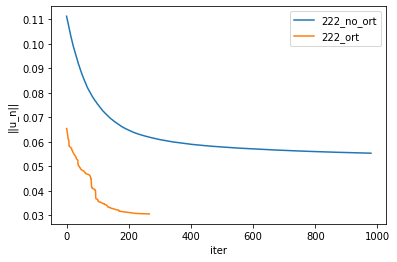

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(v_norm_222_no_ort[20:], label="222_no_ort")
ax.plot(u_norm_222[20:], label="222_ort")
ax.set_xlabel('iter')
ax.set_ylabel('||u_n||')
ax.legend()